In [1]:
#import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance
from matplotlib import collections as matcoll


In [3]:
df = pd.read_csv('/content/drive/MyDrive/DDMCS/Analisi/scores.csv')
df.head(7)

,twitter_username,mastodon_username,Twitter_TOXICITY,Twitter_SEVERE_TOXICITY,Twitter_IDENTITY_ATTACK,Twitter_INSULT,Twitter_PROFANITY,Twitter_THREAT,Mastodon_TOXICITY,Mastodon_SEVERE_TOXICITY,Mastodon_IDENTITY_ATTACK,Mastodon_INSULT,Mastodon_PROFANITY,Mastodon_THREAT
0,ivanjuarezart,tkz.one_ivanjuarezart,0.029129,0.002153,0.004220,0.019771,0.030770,0.006482,0.003762,0.000296,0.000682,0.005998,0.010410,0.005543
1,theunawarewolf,universeodon.com_theunawarewolf,0.135003,0.017387,0.020852,0.065664,0.100821,0.026605,0.386850,0.041872,0.097611,0.185161,0.324655,0.085338
2,nateplusplus,techhub.social_nateplusplus,0.076167,0.007537,0.013460,0.049011,0.055415,0.014735,0.022743,0.001666,0.004730,0.009837,0.017265,0.008505
3,jjhevel,writing.exchange_jhevel,0.041864,0.002179,0.005643,0.018268,0.027281,0.012124,0.038349,0.001734,0.007405,0.014560,0.022845,0.008757
4,gianpiero82,mastodon.uno_gianpiero82,0.088620,0.005518,0.019904,0.071827,0.049008,0.011217,0.078197,0.003559,0.014876,0.074080,0.044509,0.006781
5,AbyssGrant,socel.net_AbyssGrant,0.040816,0.002991,0.006459,0.015154,0.035685,0.012143,0.038240,0.001911,0.005614,0.015132,0.026440,0.008250
6,francoiseleste,mastodon.online_francoiseleste,0.237678,0.157053,0.230957,0.241538,0.160643,0.234195,0.201270,0.114238,0.178436,0.224116,0.144719,0.201732


# Average score analysis

In [5]:
#Divide the two distribution
tw = df.iloc[:, [0, 2,3,4,5,6,7]]
ma = df.iloc[:, [1,8,9,10,11,12,13]]

In [ ]:
# Add a score variables as mean of the others score

tw['mean_score'] = tw[['Twitter_TOXICITY','Twitter_SEVERE_TOXICITY', 'Twitter_IDENTITY_ATTACK', 'Twitter_INSULT','Twitter_PROFANITY','Twitter_THREAT']].mean(axis=1)

ma['mean_score'] = ma[['Mastodon_TOXICITY','Mastodon_SEVERE_TOXICITY', 'Mastodon_IDENTITY_ATTACK', 'Mastodon_INSULT','Mastodon_PROFANITY','Mastodon_THREAT']].mean(axis=1)

In [ ]:
tw['group'] = 'Twitter'
ma['group'] = 'Mastodon'

In [7]:
df1 = tw.iloc[:, [7,8]]
df2 = ma.iloc[:, [7,8]]
distr = pd.concat([df1,df2],ignore_index= True)

In [32]:
#create a function to find outliers using IQR

def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [53]:
len(find_outliers_IQR(tw['mean_score'])) #9%
len(find_outliers_IQR(ma['mean_score'])) #12%


47

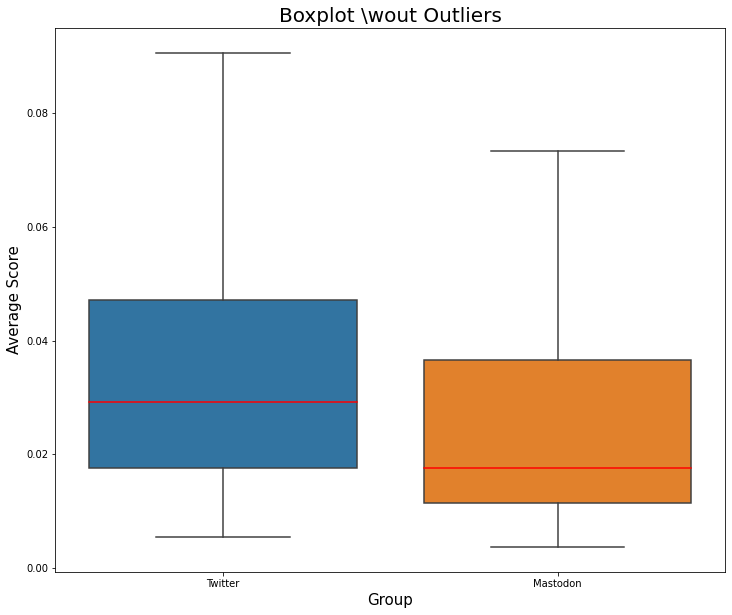

In [47]:
plt.figure(figsize = (12,10))
sns.boxplot(data=distr, x='group', y='mean_score',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers = False, medianprops=dict(color="red", alpha=1));
plt.title("Boxplot \wout Outliers", size = 20);
plt.xlabel("Group", size = 15)
plt.ylabel("Average Score", size = 15)
plt.show()

Text(0, 0.5, 'Average Score')

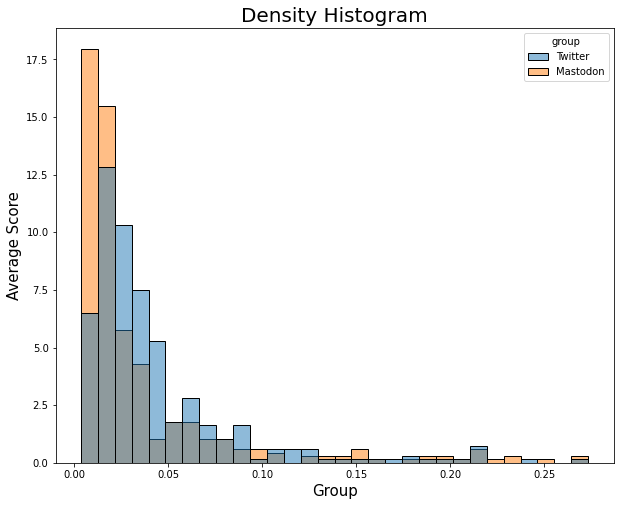

In [40]:
plt.figure(figsize = (10,8))
sns.histplot(data=distr, x='mean_score', hue='group', bins=30, stat='density', common_norm=True);
plt.title("Density Histogram",size = 20)
#plt.title("Boxplot", size = 20);
plt.xlabel("Group", size = 15)
plt.ylabel("Average Score", size = 15)

However, an important issue remains: the size of the bins is arbitrary. In the extreme, if we bunch the data less, we end up with bins with at most one observation, if we bunch the data more, we end up with a single bin. In both cases, if we exaggerate, the plot loses informativeness. This is a classical bias-variance trade-off.
Kernel Density

One possible solution is to use a kernel density function that tries to approximate the histogram with a continuous function, using kernel density estimation (KDE).

Text(0, 0.5, 'Average Score')

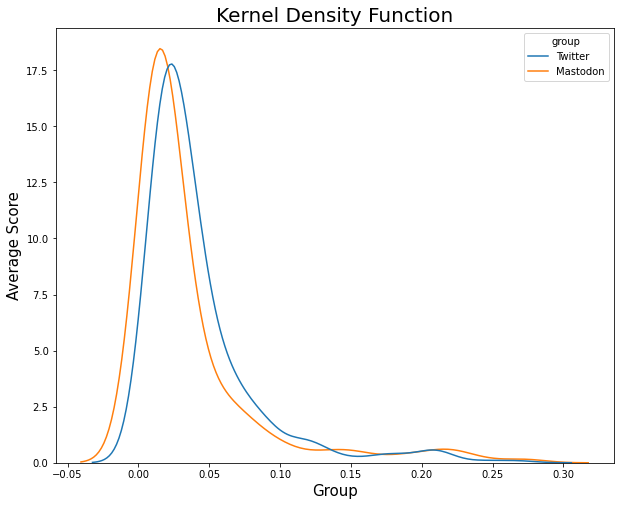

In [43]:
plt.figure(figsize = (10,8))
sns.kdeplot(x='mean_score', data=distr, hue='group', common_norm=False);
plt.title("Kernel Density Function", size = 20);
plt.xlabel("Group", size = 15)
plt.ylabel("Average Score", size = 15)

The issue with kernel density estimation is that it is a bit of a black box and might mask relevant features of the data.

In [57]:
#summary
tw['mean_score'].describe()

count    378.000000
mean       0.042357
std        0.041483
min        0.005537
25%        0.017658
50%        0.029149
75%        0.047148
max        0.267622
Name: mean_score, dtype: float64

In [59]:
ma['mean_score'].describe()

count    378.000000
mean       0.036339
std        0.048359
min        0.003690
25%        0.011432
50%        0.017627
75%        0.036557
max        0.273235
Name: mean_score, dtype: float64

In [54]:
wasserstein_distance(Twitter['mean_score'],Mastodon['mean_score'])

0.00946637325654959

In [12]:
#Extract  5% higher values
p = np.percentile(tw['mean_score'], 95) # return 50th percentile, e.g median.
print(p)

big_tw = tw[tw['mean_score'] > p]

0.12170909749309998


In [13]:
p = np.percentile(ma['mean_score'], 95) # return 50th percentile, e.g median.
print(p)

big_ma = ma[ma['mean_score'] > p]

0.1495698868816249


In both cases they are 19. Are they the same users?


In [14]:
common_avg = big_ma.index.intersection(big_tw.index) #14 are in common

In [23]:
a = tw.loc[common_avg, 'mean_score']
b = ma.loc[common_avg, 'mean_score']

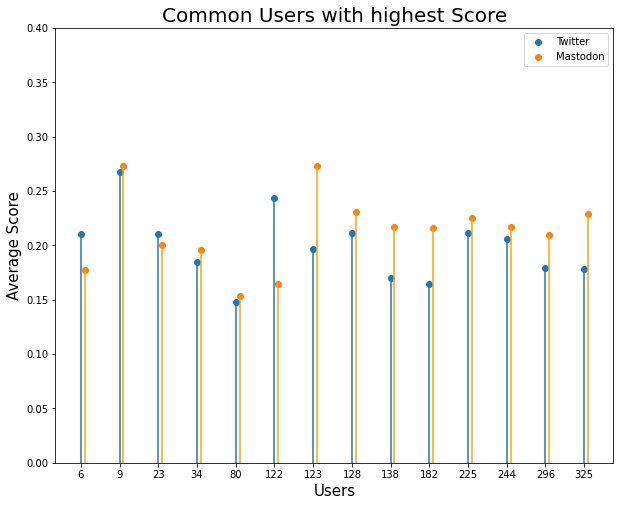

In [75]:
x = np.arange(1,15)
x1 = np.arange(1,15) + 0.1
y = a.values
y1 = b.values

lines = []
for i in range(len(x)):
    pair=[(x[i],0), (x[i], y[i])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines)
fig, ax = plt.subplots(figsize=(10, 8))
ax.add_collection(linecoll)
#plt.figure(figsize=(10, 8))
lines1 = []
for i in range(len(x)):
    pair=[(x[i],0), (x[i], y1[i])]
    lines1.append(pair)

#linecoll1 = matcoll.LineCollection(lines1)
#ax.add_collection(linecoll1)

plt.scatter(x,y, label = "Twitter")
plt.scatter(x1,y1 , label = "Mastodon")

plt.xticks(x,common_avg)
plt.ylim(0,0.4)
plt.legend()
plt.vlines(x = 1.1, ymin = 0.0,ymax =0.17741846, color = 'orange')
plt.vlines(x = 2.1, ymin = 0.0,ymax =0.273235, color = 'orange')
plt.vlines(x = 3.1, ymin = 0.0,ymax =0.200776, color = 'orange')
plt.vlines(x = 4.1, ymin = 0.0,ymax = 0.195732, color = 'orange')
plt.vlines(x = 5.1, ymin = 0.0,ymax =0.153781, color = 'orange')

plt.vlines(x = 6.1, ymin = 0.0,ymax =0.164285, color = 'orange')
plt.vlines(x = 7.1, ymin = 0.0,ymax =0.272857, color = 'orange')
plt.vlines(x = 8.1, ymin = 0.0,ymax =0.230343, color = 'orange')

plt.vlines(x = 9.1, ymin = 0.0,ymax =0.216724, color = 'orange')
plt.vlines(x = 10.1, ymin = 0.0,ymax =0.216196, color = 'orange')
plt.vlines(x = 11.1, ymin = 0.0,ymax =0.225198, color = 'orange')
plt.vlines(x = 12.1, ymin = 0.0,ymax =0.217115, color = 'orange')

plt.vlines(x = 13.1, ymin = 0.0,ymax =0.209664, color = 'orange')
plt.vlines(x = 14.1, ymin = 0.0,ymax =0.229013, color = 'orange')
plt.title('Common Users with highest Score', size = 20)
plt.xlabel('Users',size = 15)
plt.ylabel('Average Score', size = 15)
plt.show()

In [65]:
b

6      0.177418
9      0.273235
23     0.200776
34     0.195732
80     0.153781
122    0.164285
123    0.272857
128    0.230343
138    0.216724
182    0.216196
225    0.225198
244    0.217115
296    0.209664
325    0.229013
Name: mean_score, dtype: float64

Now we want to extract this users, and in particular check what increase their score the most.

* Twitter : insulti, minacce, toxicity
* Mastodon : Idem

In [33]:
#df.iloc[common]
#tw.iloc[common]

tw1 = tw.loc[:, tw.columns != 'twitter_username']
tw1.loc[common_avg, tw1.columns != 'group'].idxmax(axis=1)
#tw.idxmax(axis=1)

6        Twitter_INSULT
9        Twitter_THREAT
23       Twitter_THREAT
34       Twitter_INSULT
80       Twitter_THREAT
122      Twitter_INSULT
123    Twitter_TOXICITY
128      Twitter_THREAT
138      Twitter_THREAT
182      Twitter_THREAT
225      Twitter_INSULT
244      Twitter_THREAT
296      Twitter_THREAT
325      Twitter_THREAT
dtype: object

In [34]:
ma1 = ma.loc[:, ma.columns != 'mastodon_username']
ma1.loc[common_avg, ma1.columns != 'group'].idxmax(axis=1)

6        Mastodon_INSULT
9        Mastodon_THREAT
23       Mastodon_THREAT
34     Mastodon_TOXICITY
80       Mastodon_INSULT
122      Mastodon_INSULT
123    Mastodon_TOXICITY
128      Mastodon_THREAT
138    Mastodon_TOXICITY
182      Mastodon_THREAT
225      Mastodon_THREAT
244      Mastodon_THREAT
296      Mastodon_INSULT
325      Mastodon_THREAT
dtype: object

# TOXICITY

In [8]:
df1 =  tw.iloc[:, [1,8]]
df2 = ma.iloc[:, [1,8]]

df1.rename(columns = {'Twitter_TOXICITY':'Toxicity', 'Twitter_IDENTITY_ATTACK' : 'Identity_Attack', 'Twitter_INSULT':'Insult','Twitter_PROFANITY':'Profanity','Twitter_THREAT':'Threat' }, inplace = True)
df2.rename(columns = {'Mastodon_TOXICITY':'Toxicity','Mastodon_IDENTITY_ATTACK' : 'Identity_Attack', 'Mastodon_INSULT':'Insult','Mastodon_PROFANITY':'Profanity','Mastodon_THREAT':'Threat' }, inplace = True)

distr = pd.concat([df1,df2],ignore_index= True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


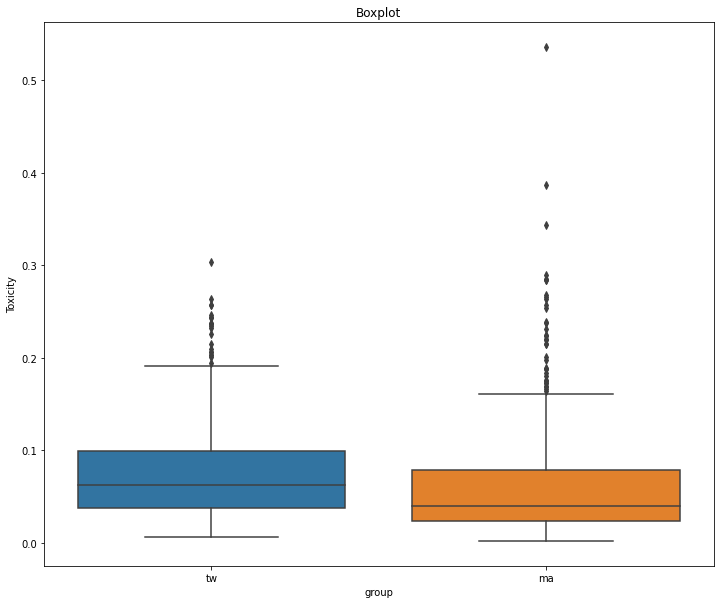

In [16]:
plt.figure(figsize = (12,10))
sns.boxplot(data=distr, x='group', y='Toxicity');
plt.title("Boxplot");
plt.show()

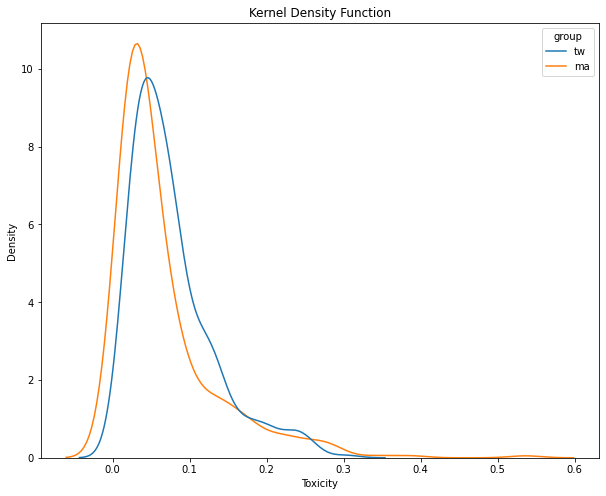

In [17]:
plt.figure(figsize = (10,8))
sns.kdeplot(x='Toxicity', data=distr, hue='group', common_norm=False);
plt.title("Kernel Density Function");

In [ ]:
sns.boxplot(data=distr, x='group', y='mean_score',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers = False, medianprops=dict(color="red", alpha=1));
plt.title("Boxplot \wout Outliers", size = 20);
plt.xlabel("Group", size = 15)
plt.ylabel("Average Score", size = 15)

Text(0.5, 0, 'Toxicity')

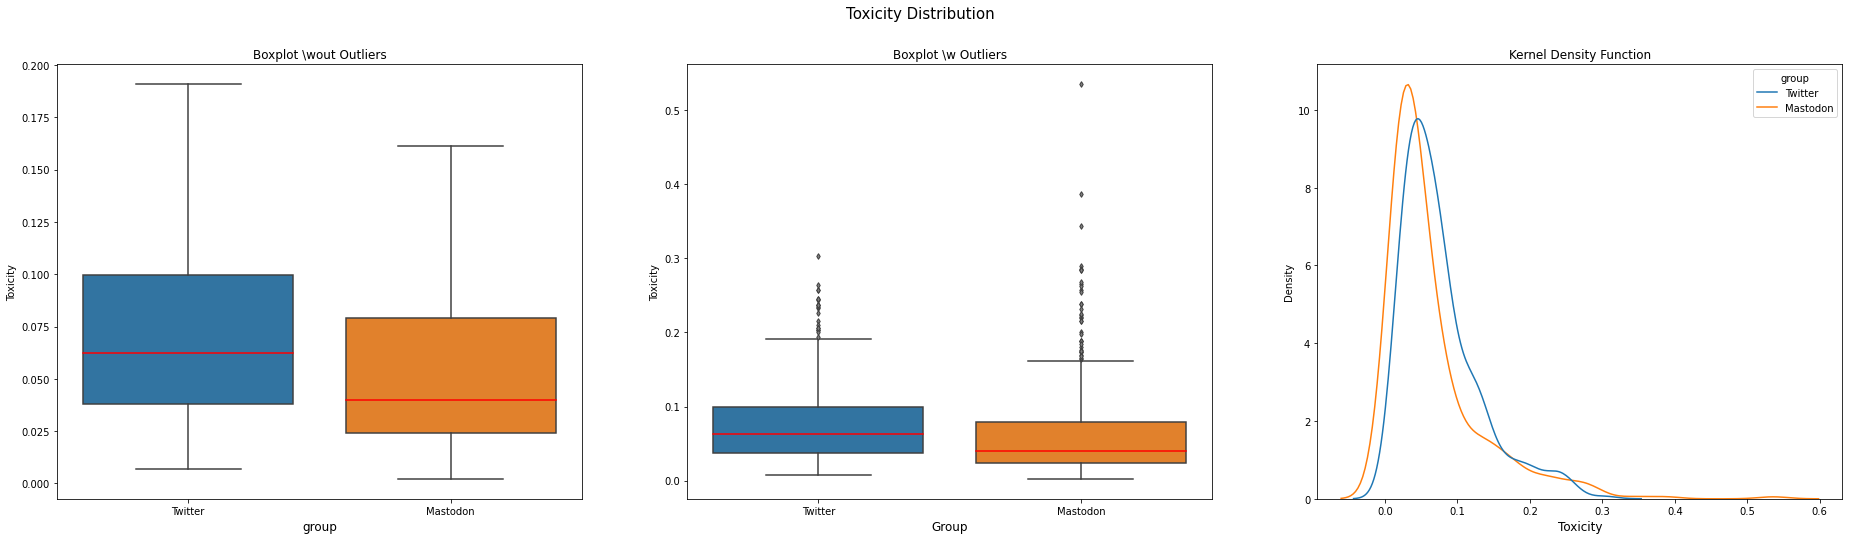

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(32,8))
fig.suptitle('Toxicity Distribution',size = 15)
axes[0].set_title("Boxplot \wout Outliers", size = 12)
axes[0].set_xlabel("Group", size = 12)
sns.boxplot(ax=axes[0], data=distr, x='group', y='Toxicity',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers = False, medianprops=dict(color="red", alpha=1))

axes[1].set_title("Boxplot \w Outliers", size = 12)
sns.boxplot(ax=axes[1], data=distr, x='group', y='Toxicity',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers =True, medianprops=dict(color="red", alpha=1))
axes[1].set_xlabel("Group", size = 12)

axes[2].set_title("Kernel Density Function", size = 12)
sns.kdeplot(x='Toxicity', data=distr, hue='group', common_norm=False)
axes[2].set_xlabel("Toxicity", size = 12)

In [34]:
len(find_outliers_IQR(tw['Twitter_TOXICITY'])) #6%
len(find_outliers_IQR(ma['Mastodon_TOXICITY'])) #9%

36

In [36]:
(36*100)/378

9.523809523809524

In [22]:
#summary
tw['Twitter_TOXICITY'].describe()


count    378.000000
mean       0.076780
std        0.054857
min        0.006963
25%        0.037772
50%        0.062401
75%        0.099607
max        0.303436
Name: Twitter_TOXICITY, dtype: float64

In [23]:
ma['Mastodon_TOXICITY'].describe()

count    378.000000
mean       0.065746
std        0.068321
min        0.002121
25%        0.023982
50%        0.040103
75%        0.079120
max        0.535794
Name: Mastodon_TOXICITY, dtype: float64

In [65]:
#Extract  5% higher values
p = np.percentile(tw['Twitter_TOXICITY'], 95) # return 50th percentile, e.g median.
print(p)

big_tw = tw[tw['Twitter_TOXICITY'] > p]

p = np.percentile(ma['Mastodon_TOXICITY'], 95) # return 50th percentile, e.g median.
print(p)

big_ma = ma[ma['Mastodon_TOXICITY'] > p]

0.20151347125046373
0.21569098398999992


In [66]:
common_toxicity = big_ma.index.intersection(big_tw.index) #7

In [27]:
common_toxicity 

Int64Index([9, 23, 34, 123, 128, 225, 325], dtype='int64')

In [28]:
df.loc[common_toxicity, :]

,twitter_username,mastodon_username,Twitter_TOXICITY,Twitter_SEVERE_TOXICITY,Twitter_IDENTITY_ATTACK,Twitter_INSULT,Twitter_PROFANITY,Twitter_THREAT,Mastodon_TOXICITY,Mastodon_SEVERE_TOXICITY,Mastodon_IDENTITY_ATTACK,Mastodon_INSULT,Mastodon_PROFANITY,Mastodon_THREAT
9,Rauchz3ich3n,social.cologne_rauchz3ch3n,0.303436,0.214174,0.298389,0.286589,0.187362,0.315783,0.289189,0.189434,0.308875,0.234998,0.156876,0.460038
23,mawedler2,social.dev-wiki.de_mawedler,0.243401,0.165109,0.224213,0.208912,0.127807,0.294167,0.218950,0.164998,0.126014,0.163749,0.124688,0.406257
34,victorredman,mas.to_victorredman,0.214989,0.149261,0.152848,0.215787,0.166496,0.208882,0.257519,0.217535,0.121828,0.165419,0.238214,0.173880
123,BluejayPrime,universeodon.com_bluejayprime,0.232357,0.164655,0.177430,0.228759,0.173881,0.205378,0.343215,0.219902,0.233856,0.334765,0.240272,0.265130
128,thedianatavares,mastodon.social_thedianatavares,0.206499,0.201611,0.228786,0.211923,0.173038,0.245757,0.220545,0.147685,0.267610,0.166107,0.108266,0.471843
225,derfeinekali,social.anoxinon.de_derfeinekali,0.245803,0.175596,0.197465,0.249313,0.178462,0.219582,0.263047,0.197304,0.119635,0.158856,0.091759,0.520588
325,Roessix,gruene.social_klaus,0.206474,0.119387,0.196513,0.210261,0.113714,0.223691,0.283661,0.155449,0.267012,0.246766,0.108323,0.312870


# SEVERE TOXICITY

In [67]:
df1 =  tw.iloc[:, [2,8]]
df2 = ma.iloc[:, [2,8]]

df1.rename(columns = {'Twitter_TOXICITY':'Toxicity', 'Twitter_SEVERE_TOXICITY': 'SEVERE_Toxicity', 'Twitter_IDENTITY_ATTACK' : 'Identity_Attack', 'Twitter_INSULT':'Insult','Twitter_PROFANITY':'Profanity','Twitter_THREAT':'Threat' }, inplace = True)
df2.rename(columns = {'Mastodon_TOXICITY':'Toxicity', 'Mastodon_SEVERE_TOXICITY': 'SEVERE_Toxicity','Mastodon_IDENTITY_ATTACK' : 'Identity_Attack', 'Mastodon_INSULT':'Insult','Mastodon_PROFANITY':'Profanity','Mastodon_THREAT':'Threat' }, inplace = True)

distr = pd.concat([df1,df2],ignore_index= True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Text(0.5, 0, 'SEVERE Toxicity')

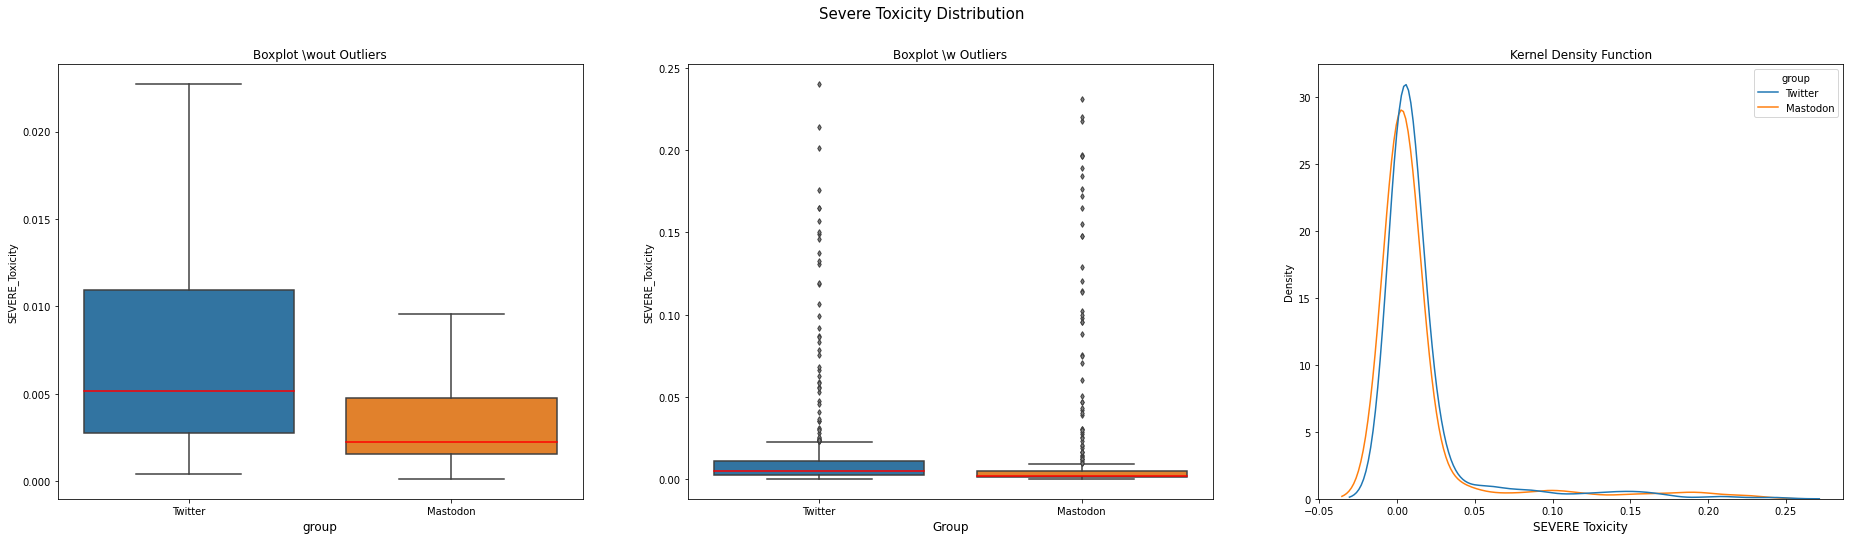

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(32,8))
fig.suptitle('Severe Toxicity Distribution',size = 15)
axes[0].set_title("Boxplot \wout Outliers", size = 12)
axes[0].set_xlabel("Group", size = 12)
sns.boxplot(ax=axes[0], data=distr, x='group', y='SEVERE_Toxicity',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers = False, medianprops=dict(color="red", alpha=1))

axes[1].set_title("Boxplot \w Outliers", size = 12)
sns.boxplot(ax=axes[1], data=distr, x='group', y='SEVERE_Toxicity',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers =True, medianprops=dict(color="red", alpha=1))
axes[1].set_xlabel("Group", size = 12)

axes[2].set_title("Kernel Density Function", size = 12)
sns.kdeplot(x='SEVERE_Toxicity', data=distr, hue='group', common_norm=False)
axes[2].set_xlabel('SEVERE Toxicity', size = 12)

In [41]:
len(find_outliers_IQR(tw['Twitter_SEVERE_TOXICITY'])) #14%
#len(find_outliers_IQR(ma['Mastodon_SEVERE_TOXICITY'])) #15%

52

In [35]:
#summary
print(tw['Twitter_SEVERE_TOXICITY'].describe())
ma['Mastodon_SEVERE_TOXICITY'].describe()

count    378.000000
mean       0.016092
std        0.033927
min        0.000379
25%        0.002738
50%        0.005137
75%        0.010949
max        0.240441
Name: Twitter_SEVERE_TOXICITY, dtype: float64


count    378.000000
mean       0.014536
std        0.038921
min        0.000111
25%        0.001520
50%        0.002216
75%        0.004738
max        0.231352
Name: Mastodon_SEVERE_TOXICITY, dtype: float64

In [68]:
#Extract  5% higher values
p = np.percentile(tw['Twitter_SEVERE_TOXICITY'], 95) # return 50th percentile, e.g median.
print(p)

big_tw = tw[tw['Twitter_SEVERE_TOXICITY'] > p]

p = np.percentile(ma['Mastodon_SEVERE_TOXICITY'], 95) # return 50th percentile, e.g median.
print(p)

big_ma = ma[ma['Mastodon_SEVERE_TOXICITY'] > p]

0.08634156297176787
0.10020275359977672


In [69]:
common_severe_toxicity = big_ma.index.intersection(big_tw.index) 
len(common_severe_toxicity)

17

In [ ]:
df.loc[common_severe_toxicity, :]

# IDENTITY_ATTACK

In [44]:
df1 =  tw.iloc[:, [3,8]]
df2 = ma.iloc[:, [3,8]]

df1.rename(columns = {'Twitter_TOXICITY':'Toxicity', 'Twitter_SEVERE_TOXICITY': 'SEVERE_Toxicity', 'Twitter_IDENTITY_ATTACK' : 'Identity_Attack', 'Twitter_INSULT':'Insult','Twitter_PROFANITY':'Profanity','Twitter_THREAT':'Threat' }, inplace = True)
df2.rename(columns = {'Mastodon_TOXICITY':'Toxicity', 'Mastodon_SEVERE_TOXICITY': 'SEVERE_Toxicity','Mastodon_IDENTITY_ATTACK' : 'Identity_Attack', 'Mastodon_INSULT':'Insult','Mastodon_PROFANITY':'Profanity','Mastodon_THREAT':'Threat' }, inplace = True)

distr = pd.concat([df1,df2],ignore_index= True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Text(0.5, 0, 'Identity Attack')

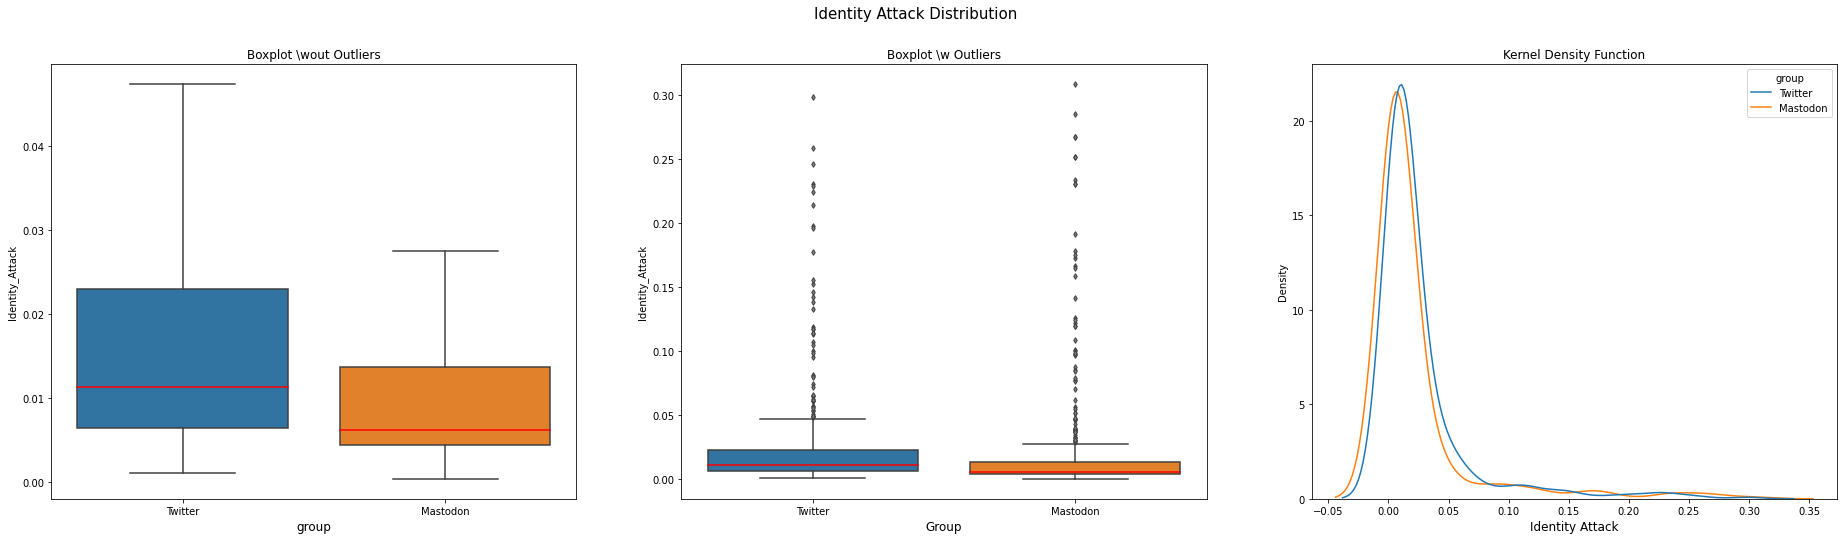

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(32,8))
fig.suptitle('Identity Attack Distribution',size = 15)
axes[0].set_title("Boxplot \wout Outliers", size = 12)
axes[0].set_xlabel("Group", size = 12)
sns.boxplot(ax=axes[0], data=distr, x='group', y='Identity_Attack',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers = False, medianprops=dict(color="red", alpha=1))

axes[1].set_title("Boxplot \w Outliers", size = 12)
sns.boxplot(ax=axes[1], data=distr, x='group', y='Identity_Attack',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers =True, medianprops=dict(color="red", alpha=1))
axes[1].set_xlabel("Group", size = 12)

axes[2].set_title("Kernel Density Function", size = 12)
sns.kdeplot(x='Identity_Attack', data=distr, hue='group', common_norm=False)
axes[2].set_xlabel('Identity Attack', size = 12)

In [49]:
len(find_outliers_IQR(ma['Mastodon_IDENTITY_ATTACK'])) #14%
#len(find_outliers_IQR(ma['Identity_Attack'])) #15%

64

In [50]:
6400/378

16.93121693121693

In [42]:
#summary
print(tw['Twitter_IDENTITY_ATTACK'].describe())
ma['Mastodon_IDENTITY_ATTACK'].describe()

count    378.000000
mean       0.026233
std        0.042789
min        0.000994
25%        0.006382
50%        0.011298
75%        0.022975
max        0.298389
Name: Twitter_IDENTITY_ATTACK, dtype: float64


count    378.000000
mean       0.023136
std        0.048506
min        0.000331
25%        0.004412
50%        0.006134
75%        0.013693
max        0.308875
Name: Mastodon_IDENTITY_ATTACK, dtype: float64

In [72]:
#Extract  5% higher values
p = np.percentile(tw['Twitter_IDENTITY_ATTACK'], 95) # return 50th percentile, e.g median.
print(p)

big_tw = tw[tw['Twitter_IDENTITY_ATTACK'] > p]

p = np.percentile(ma['Mastodon_IDENTITY_ATTACK'], 95) # return 50th percentile, e.g median.
print(p)

big_ma = ma[ma['Mastodon_IDENTITY_ATTACK'] > p]

0.11504666883655867
0.1221659274821428


In [73]:
common_id_attack = big_ma.index.intersection(big_tw.index) 
len(common_id_attack) 

15

# INSULT

In [52]:
df1 =  tw.iloc[:, [4,8]]
df2 = ma.iloc[:, [4,8]]

df1.rename(columns = {'Twitter_TOXICITY':'Toxicity', 'Twitter_SEVERE_TOXICITY': 'SEVERE_Toxicity', 'Twitter_IDENTITY_ATTACK' : 'Identity_Attack', 'Twitter_INSULT':'Insult','Twitter_PROFANITY':'Profanity','Twitter_THREAT':'Threat' }, inplace = True)
df2.rename(columns = {'Mastodon_TOXICITY':'Toxicity', 'Mastodon_SEVERE_TOXICITY': 'SEVERE_Toxicity','Mastodon_IDENTITY_ATTACK' : 'Identity_Attack', 'Mastodon_INSULT':'Insult','Mastodon_PROFANITY':'Profanity','Mastodon_THREAT':'Threat' }, inplace = True)

distr = pd.concat([df1,df2],ignore_index= True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Text(0.5, 0, 'Insult')

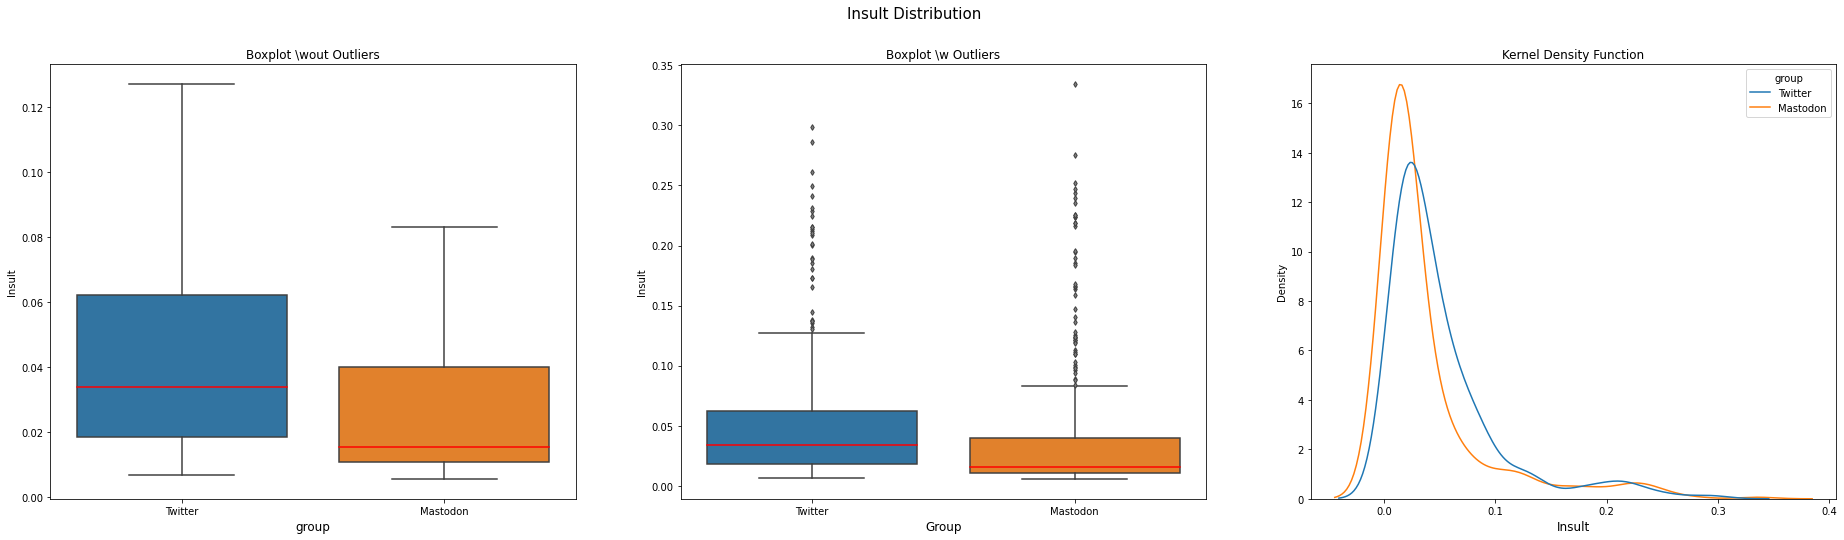

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(32,8))
fig.suptitle('Insult Distribution',size = 15)
axes[0].set_title("Boxplot \wout Outliers", size = 12)
axes[0].set_xlabel("Group", size = 12)
sns.boxplot(ax=axes[0], data=distr, x='group', y='Insult',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers = False, medianprops=dict(color="red", alpha=1))

axes[1].set_title("Boxplot \w Outliers", size = 12)
sns.boxplot(ax=axes[1], data=distr, x='group', y='Insult',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers =True, medianprops=dict(color="red", alpha=1))
axes[1].set_xlabel("Group", size = 12)

axes[2].set_title("Kernel Density Function", size = 12)
sns.kdeplot(x='Insult', data=distr, hue='group', common_norm=False)
axes[2].set_xlabel('Insult', size = 12)

In [55]:
len(find_outliers_IQR(tw['Twitter_INSULT'])) #30 --> 8%
len(find_outliers_IQR(ma['Mastodon_INSULT'])) #49 --> 13%


49

In [13]:
#summary
print(tw['Twitter_INSULT'].describe())
ma['Mastodon_INSULT'].describe()

count    378.000000
mean       0.051345
std        0.051810
min        0.006772
25%        0.018383
50%        0.033814
75%        0.062198
max        0.298297
Name: Twitter_INSULT, dtype: float64


count    378.000000
mean       0.039282
std        0.054531
min        0.005546
25%        0.010838
50%        0.015499
75%        0.040023
max        0.334765
Name: Mastodon_INSULT, dtype: float64

In [74]:
#Extract  5% higher values
p = np.percentile(tw['Twitter_INSULT'], 95) # return 50th percentile, e.g median.
print(p)

big_tw = tw[tw['Twitter_INSULT'] > p]

p = np.percentile(ma['Mastodon_INSULT'], 95) # return 50th percentile, e.g median.
print(p)

big_ma = ma[ma['Mastodon_INSULT'] > p]

0.18116072302306835
0.17005794417857106


In [75]:
common_insult = big_ma.index.intersection(big_tw.index) 
len(common_insult) #9

9

# PROFANITY

In [56]:
df1 =  tw.iloc[:, [5,8]]
df2 = ma.iloc[:, [5,8]]

df1.rename(columns = {'Twitter_TOXICITY':'Toxicity', 'Twitter_SEVERE_TOXICITY': 'SEVERE_Toxicity', 'Twitter_IDENTITY_ATTACK' : 'Identity_Attack', 'Twitter_INSULT':'Insult','Twitter_PROFANITY':'Profanity','Twitter_THREAT':'Threat' }, inplace = True)
df2.rename(columns = {'Mastodon_TOXICITY':'Toxicity', 'Mastodon_SEVERE_TOXICITY': 'SEVERE_Toxicity','Mastodon_IDENTITY_ATTACK' : 'Identity_Attack', 'Mastodon_INSULT':'Insult','Mastodon_PROFANITY':'Profanity','Mastodon_THREAT':'Threat' }, inplace = True)

distr = pd.concat([df1,df2],ignore_index= True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Text(0.5, 0, 'Profanity')

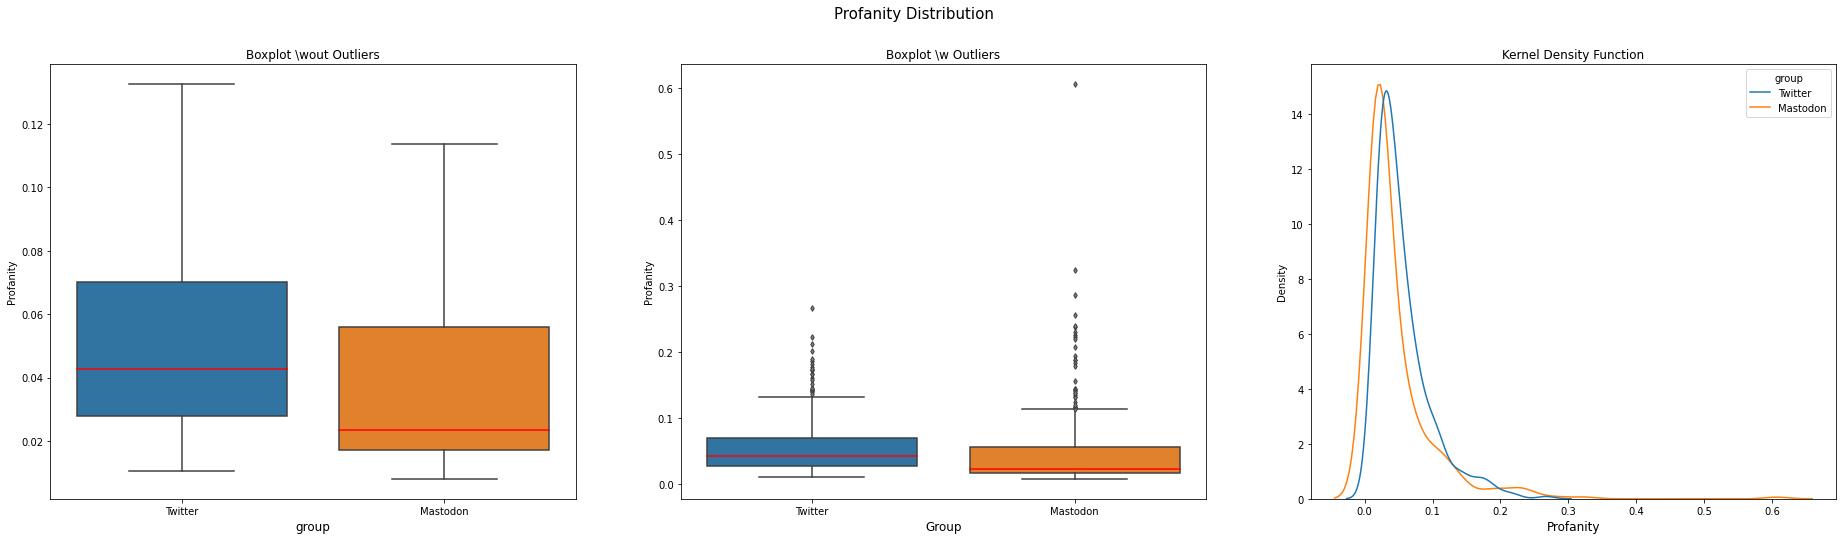

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(32,8))
fig.suptitle('Profanity Distribution',size = 15)
axes[0].set_title("Boxplot \wout Outliers", size = 12)
axes[0].set_xlabel("Group", size = 12)
sns.boxplot(ax=axes[0], data=distr, x='group', y='Profanity',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers = False, medianprops=dict(color="red", alpha=1))

axes[1].set_title("Boxplot \w Outliers", size = 12)
sns.boxplot(ax=axes[1], data=distr, x='group', y='Profanity',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers =True, medianprops=dict(color="red", alpha=1))
axes[1].set_xlabel("Group", size = 12)

axes[2].set_title("Kernel Density Function", size = 12)
sns.kdeplot(x='Profanity', data=distr, hue='group', common_norm=False)
axes[2].set_xlabel('Profanity', size = 12)

In [59]:
len(find_outliers_IQR(tw['Twitter_PROFANITY'])) #23 --> 7%
len(find_outliers_IQR(ma['Mastodon_PROFANITY'])) #33 --> 9%

33

In [20]:
#summary
print(tw['Twitter_PROFANITY'].describe())
ma['Mastodon_PROFANITY'].describe()

count    378.000000
mean       0.055578
std        0.040457
min        0.010535
25%        0.027799
50%        0.042846
75%        0.070282
max        0.266910
Name: Twitter_PROFANITY, dtype: float64


count    378.000000
mean       0.046455
std        0.056866
min        0.007981
25%        0.017218
50%        0.023413
75%        0.055855
max        0.606948
Name: Mastodon_PROFANITY, dtype: float64

In [76]:
#Extract  5% higher values
p = np.percentile(tw['Twitter_PROFANITY'], 95) # return 50th percentile, e.g median.
print(p)

big_tw = tw[tw['Twitter_PROFANITY'] > p]

p = np.percentile(ma['Mastodon_PROFANITY'], 95) # return 50th percentile, e.g median.
print(p)

big_ma = ma[ma['Mastodon_PROFANITY'] > p]

0.1427383119796546
0.142454054547159


In [77]:
common_prof = big_ma.index.intersection(big_tw.index) 
len(common_prof) #6

6

# THREAT


In [63]:
df1 =  tw.iloc[:, [6,8]]
df2 = ma.iloc[:, [6,8]]

df1.rename(columns = {'Twitter_TOXICITY':'Toxicity', 'Twitter_SEVERE_TOXICITY': 'SEVERE_Toxicity', 'Twitter_IDENTITY_ATTACK' : 'Identity_Attack', 'Twitter_INSULT':'Insult','Twitter_PROFANITY':'Profanity','Twitter_THREAT':'Threat' }, inplace = True)
df2.rename(columns = {'Mastodon_TOXICITY':'Toxicity', 'Mastodon_SEVERE_TOXICITY': 'SEVERE_Toxicity','Mastodon_IDENTITY_ATTACK' : 'Identity_Attack', 'Mastodon_INSULT':'Insult','Mastodon_PROFANITY':'Profanity','Mastodon_THREAT':'Threat' }, inplace = True)

distr = pd.concat([df1,df2],ignore_index= True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Text(0.5, 0, 'Threat')

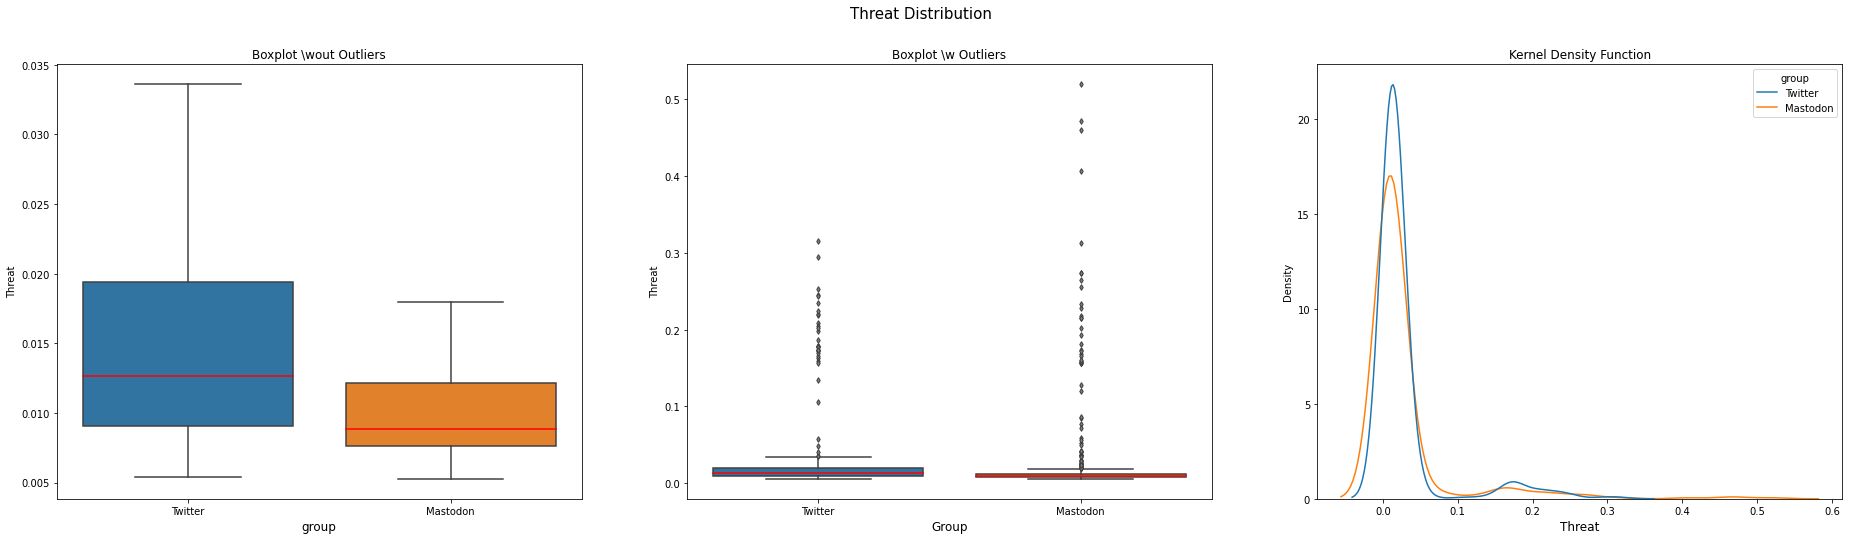

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(32,8))
fig.suptitle('Threat Distribution',size = 15)
axes[0].set_title("Boxplot \wout Outliers", size = 12)
axes[0].set_xlabel("Group", size = 12)
sns.boxplot(ax=axes[0], data=distr, x='group', y='Threat',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers = False, medianprops=dict(color="red", alpha=1))

axes[1].set_title("Boxplot \w Outliers", size = 12)
sns.boxplot(ax=axes[1], data=distr, x='group', y='Threat',flierprops = dict(markerfacecolor = '0.50', markersize = 4),showfliers =True, medianprops=dict(color="red", alpha=1))
axes[1].set_xlabel("Group", size = 12)

axes[2].set_title("Kernel Density Function", size = 12)
sns.kdeplot(x='Threat', data=distr, hue='group', common_norm=False)
axes[2].set_xlabel('Threat', size = 12)

In [61]:
len(find_outliers_IQR(tw['Twitter_THREAT'])) #34 --> 9%
len(find_outliers_IQR(ma['Mastodon_THREAT'])) #66 --> 18%

66

In [26]:
#summary
print(tw['Twitter_THREAT'].describe())
ma['Mastodon_THREAT'].describe()

count    378.000000
mean       0.028111
std        0.050728
min        0.005426
25%        0.009095
50%        0.012630
75%        0.019436
max        0.315783
Name: Twitter_THREAT, dtype: float64


count    378.000000
mean       0.028876
std        0.066760
min        0.005254
25%        0.007600
50%        0.008876
75%        0.012151
max        0.520588
Name: Mastodon_THREAT, dtype: float64

In [70]:
#Extract  5% higher values
p = np.percentile(tw['Twitter_THREAT'], 95) # return 50th percentile, e.g median.
print(p)

big_tw = tw[tw['Twitter_THREAT'] > p]

p = np.percentile(ma['Mastodon_THREAT'], 95) # return 50th percentile, e.g median.
print(p)

big_ma = ma[ma['Mastodon_THREAT'] > p]

0.17368598201715682
0.1688816700833332


In [71]:
common_threat = big_ma.index.intersection(big_tw.index) 
len(common_threat) #6

16

Cose da vedere : 
* quanti Hub separatamente + quali sono hub in tutto (ex. 6 e 9 ?).
* Boxplot con e senza dati anomali
* Quali divergono di più?

The Mann-Whitney U Test is a null hypothesis test, used to detect differences between two independent data sets. The test is specifically for non-parametric distributions, which do not assume a specific distribution for a set of data. Because of this, the Mann-Whitney U Test can be applied to any distribution, whether it is Gaussian or not.



Specifically, the null hypothesis of the Mann-Whitney U Test states that the distributions of two data sets are identical. 

As a general rule of thumb, when the p-value is below 0.05, the null hypothesis can be rejected.

In [30]:
def mann_whitney_u_test(distribution_1, distribution_2):
    """
    Perform the Mann-Whitney U Test, comparing two different distributions.
    Args:
       distribution_1: List. 
       distribution_2: List.
    Outputs:
        u_statistic: Float. U statisitic for the test.
        p_value: Float.
    """
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2)
    return u_statistic, p_value

In [31]:
#Perform the Mann-Whitney U Test on the two distributions --> sono diverse
mann_whitney_u_test(list(tw['mean_score']), list(ma['mean_score'])) 

(91844.0, 1.080355906445439e-11)

# Users

In [136]:
z = tw.loc[common_severe_toxicity, : 'Twitter_SEVERE_TOXICITY']
w = ma.loc[common_severe_toxicity, : 'Mastodon_SEVERE_TOXICITY']

In [138]:
z.iloc[:,2].values

array([0.1570532 , 0.21417389, 0.16510903, 0.14926085, 0.1186435 ,
       0.2404406 , 0.16465497, 0.20161105, 0.1377301 , 0.09177614,
       0.09895283, 0.13103312, 0.17559621, 0.14586725, 0.08736122,
       0.1324428 , 0.11938725])

In [125]:
len(common_severe_toxicity)


17

In [81]:
len(common_id_attack)


15

In [82]:
len(common_insult)


9

In [86]:
common_prof


Int64Index([6, 9, 34, 123, 138, 296], dtype='int64')

In [95]:
common_threat.intersection(common_prof).intersection(common_insult).intersection(common_toxicity)

Int64Index([9, 123], dtype='int64')

In [102]:
ma.loc[9,:]

mastodon_username           social.cologne_rauchz3ch3n
Mastodon_TOXICITY                             0.289189
Mastodon_SEVERE_TOXICITY                      0.189434
Mastodon_IDENTITY_ATTACK                      0.308875
Mastodon_INSULT                               0.234998
Mastodon_PROFANITY                            0.156876
Mastodon_THREAT                               0.460038
mean_score                                    0.273235
group                                         Mastodon
Name: 9, dtype: object

In [120]:
w.iloc[:,1].values

array([0.28918866, 0.21895008, 0.25751851, 0.34321483, 0.22054477,
       0.26304732, 0.28366102])

# Toxicity

Text(0.5, 1.0, 'Highest Score Toxicity')

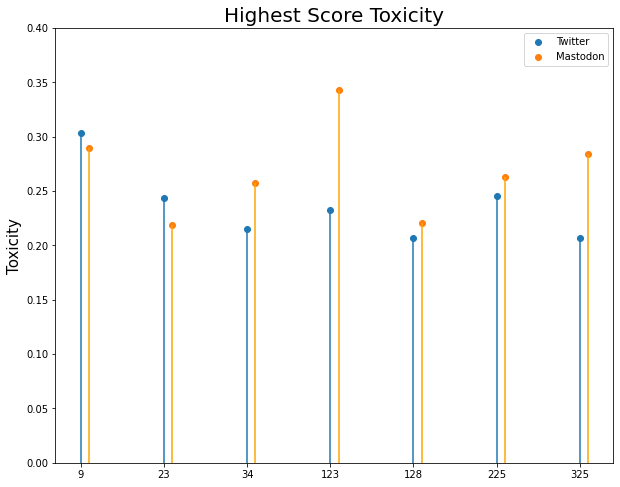

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections as matcoll

x = np.arange(1,8)
x1 = np.arange(1,8) + 0.1
y = z.iloc[:,1].values
y1 = w.iloc[:,1].values

lines = []
for i in range(len(x)):
    pair=[(x[i],0), (x[i], y[i])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines)
fig, ax = plt.subplots(figsize=(10, 8))
ax.add_collection(linecoll)
#plt.figure(figsize=(10, 8))
lines1 = []
for i in range(len(x)):
    pair=[(x[i],0), (x[i], y1[i])]
    lines1.append(pair)

#linecoll1 = matcoll.LineCollection(lines1)
#ax.add_collection(linecoll1)

plt.scatter(x,y, label = "Twitter")
plt.scatter(x1,y1 , label = "Mastodon")

plt.xticks(x,common_toxicity)
plt.ylim(0,0.4)
plt.legend()

plt.vlines(x = 1.1, ymin = 0.0,ymax =0.28918866, color = 'orange')
plt.vlines(x = 2.1, ymin = 0.0,ymax =0.21895008, color = 'orange')
plt.vlines(x = 3.1, ymin = 0.0,ymax =0.25751851, color = 'orange')
plt.vlines(x = 4.1, ymin = 0.0,ymax = 0.34321483, color = 'orange')
plt.vlines(x = 5.1, ymin = 0.0,ymax =0.22054477, color = 'orange')

plt.vlines(x = 6.1, ymin = 0.0,ymax =0.26304732, color = 'orange')
plt.vlines(x = 7.1, ymin = 0.0,ymax =0.28366102, color = 'orange')
#plt.vlines(x = 8.1, ymin = 0.0,ymax =0.230343, color = 'orange')
plt.ylabel('Toxicity', size = 15)
plt.title('Highest Score Toxicity',size = 20)

# SEVERE TOXICITY

Text(0.5, 1.0, 'Highest Score Severe Toxicity')

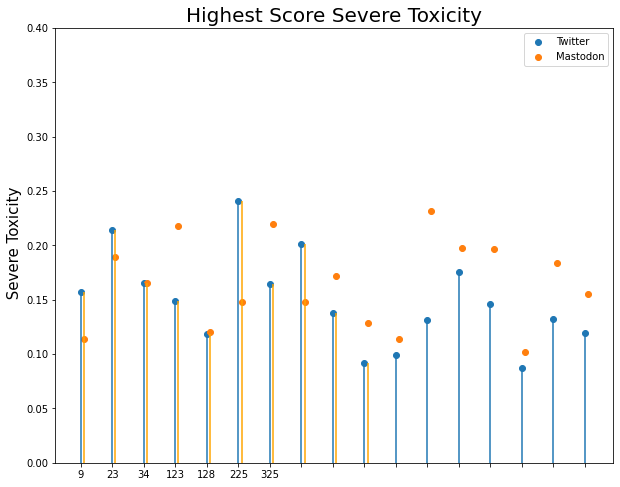

In [141]:
x = np.arange(1,18)
x1 = np.arange(1,18) + 0.1
y = z.iloc[:,2].values
y1 = w.iloc[:,2].values

lines = []
for i in range(len(x)):
    pair=[(x[i],0), (x[i], y[i])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines)
fig, ax = plt.subplots(figsize=(10, 8))
ax.add_collection(linecoll)
#plt.figure(figsize=(10, 8))
lines1 = []
for i in range(len(x)):
    pair=[(x[i],0), (x[i], y1[i])]
    lines1.append(pair)

#linecoll1 = matcoll.LineCollection(lines1)
#ax.add_collection(linecoll1)

plt.scatter(x,y, label = "Twitter")
plt.scatter(x1,y1 , label = "Mastodon")

plt.xticks(x,common_toxicity)
plt.ylim(0,0.4)
plt.legend()


      
#0.09895283, 0.13103312, 0.17559621, 0.14586725, 0.08736122,
#0.1324428 , 0.11938725



plt.vlines(x = 1.1, ymin = 0.0,ymax =0.1570532, color = 'orange')
plt.vlines(x = 2.1, ymin = 0.0,ymax =0.21417389, color = 'orange')
plt.vlines(x = 3.1, ymin = 0.0,ymax =0.16510903, color = 'orange')
plt.vlines(x = 4.1, ymin = 0.0,ymax = 0.14926085, color = 'orange')
plt.vlines(x = 5.1, ymin = 0.0,ymax =0.1186435, color = 'orange')

plt.vlines(x = 6.1, ymin = 0.0,ymax =0.2404406, color = 'orange')
plt.vlines(x = 7.1, ymin = 0.0,ymax =0.16465497, color = 'orange')
plt.vlines(x = 8.1, ymin = 0.0,ymax =0.20161105, color = 'orange')
plt.vlines(x = 9.1, ymin = 0.0,ymax =0.1377301, color = 'orange')
plt.vlines(x = 10.1, ymin = 0.0,ymax =0.09177614, color = 'orange')

plt.ylabel(' Severe Toxicity', size = 15)
plt.title('Highest Score Severe Toxicity',size = 20)